In [3]:
# Video de apoyo
# https://www.youtube.com/watch?v=CsXCeOiKRZw&ab_channel=Ra%C3%BAlValerio-Statistics
# En este tutorial se eligen la cantidad de clusters al ojo, con un método visual.

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# manejo de errores y warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(8,4)})

In [4]:
# Importo los datos de venta
df_original = pd.read_excel('BD/online_retail_II.xlsx',
                   usecols=['Invoice', 'Quantity','InvoiceDate', 'Price', 'Customer ID'])
df_original.sample(5)

,Invoice,Quantity,InvoiceDate,Price,Customer ID
474126,534041,12,2010-11-19 16:41:00,0.85,17648.0
273750,515956,2,2010-07-15 19:56:00,7.95,13291.0
328976,521484,1,2010-09-06 13:26:00,4.95,17585.0
406519,528331,4,2010-10-21 13:39:00,14.95,NaN
206295,509347,1,2010-05-21 13:09:00,2.96,NaN


In [5]:
df = df_original.copy()
# Modifico el dataframe para que cada columna sea más descriptiva
df =  df.rename(columns={
        'Invoice':'order_id',
        'Quantity':'quantity',
        'InvoiceDate':'order_date',
        'Price':'unit_price',
        'Customer ID':'customer_id'})

df.describe()

,quantity,order_date,unit_price,customer_id
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


### Analisis rápido de resultados
Se observa que existen cantidades de -9600 como mínimo y cantidades de -53594 tambien existen máximos de 19152 en cantidad y precio unitario de 25111, estos outliers pueden ser notas de crédito y ventas extraordinarias, pero al ver la media se puede deducir que son datos muy salidos de la media que pueden perjudicar el análisis.

Procedo a adecuar el dataset para limpiarlo de los datos que puedan distorcionar resultados

In [6]:
# Busco lineas donde la cantidad sea negativa y también lo sea el precio
df[(df.quantity < 0) & (df.unit_price < 0)]

# Busco lineas donde la cantidad sea negativa o el precio sea negativo
df[(df.quantity < 0) | (df.unit_price < 0)]

,order_id,quantity,order_date,unit_price,customer_id
178,C489449,-12,2009-12-01 10:33:00,2.95,16321.0
179,C489449,-6,2009-12-01 10:33:00,1.65,16321.0
180,C489449,-4,2009-12-01 10:33:00,4.25,16321.0
181,C489449,-6,2009-12-01 10:33:00,2.10,16321.0
182,C489449,-12,2009-12-01 10:33:00,2.95,16321.0
...,...,...,...,...,...
525231,538159,-18,2010-12-09 17:17:00,0.00,NaN
525232,538158,-32,2010-12-09 17:17:00,0.00,NaN
525234,538161,-100,2010-12-09 17:25:00,0.00,NaN
525235,538162,-100,2010-12-09 17:25:00,0.00,NaN


In [7]:
# Cómo encontré 12329 lineas con negativos voy a filtrar esos datos
# seleccionando unicamente valores positivos en ambas columnas

df = df[(df.quantity > 0) & (df.unit_price > 0)]

# Busco también si hay valores nulos
df.isna().sum(axis=0)

order_id            0
quantity            0
order_date          0
unit_price          0
customer_id    103902
dtype: int64

Vemos que existen 103902 datos sin customer_id 

### RFM 
#### _Engineer Features to cluster_.

Construcción de variables que involucren el comportamiento del cliente

<p><b>Recency (Actualidad)</b>: ¿Cuánto tiempo ha pasado desde que el cliente ordenó algo?
    <ul>
        <li>* Low: recientemente</li>
        <li>* High: Hace mucho tiempo</li>
    </ul>
</p>
<p>
<b>Frecuency (Frecuencia)</b>:¿Con qué frecuencia el cliente ha realizado pedidos o interactuado con la empresa dentro de un período determinado?
</p>
<p>
<b>Montery (gasto)</b>: ¿Cuánto ha gastado el cliente durante un período específico?
</p>

In [8]:
# Monetary -> Compra total
df['line_price'] = df.unit_price * df.quantity
df =  df[df.line_price > 0]
df.sample(10)

,order_id,quantity,order_date,unit_price,customer_id,line_price
406299,528321,3,2010-10-21 12:53:00,1.95,14606.0,5.85
13242,490471,2,2009-12-06 12:28:00,1.25,15878.0,2.50
319409,520516,5,2010-08-26 13:52:00,7.49,16242.0,37.45
120648,500901,16,2010-03-11 10:05:00,4.25,13093.0,68.00
246439,513248,24,2010-06-23 10:49:00,1.25,12792.0,30.00
65935,495276,12,2010-01-22 11:28:00,35.95,14063.0,431.40
482291,534631,2,2010-11-23 12:57:00,0.42,18047.0,0.84
456580,532674,1,2010-11-14 11:54:00,1.25,NaN,1.25
115483,500356,1,2010-03-07 15:34:00,1.25,16984.0,1.25
398323,527459,2,2010-10-18 10:32:00,8.50,16069.0,17.00


In [9]:
# Recency -> calculo del tiempo desde la última compra
# Calculo la fecha máxima y le agrego 1 día más para realizar la resta
end_date = max(df.order_date) + dt.timedelta(days=1)

In [10]:

df_rfm = df.groupby('customer_id').agg(
    
    recency=('order_date', lambda x: (end_date - x.max()).days ),
    frecuency=('order_id', 'count'),
    monetary=('line_price', 'sum')
)

df_rfm.head(5)

,recency,frecuency,monetary
customer_id,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2671.14
12351.0,11,21,300.93


In [11]:
# Si compruebo la existencia de nulos no deberian de haber ya que al
# agrupar por customer_id se quedaron excluidos.
df_rfm.isna().sum(axis=0)

recency      0
frecuency    0
monetary     0
dtype: int64

### Exploración de los datos

In [12]:
print('\nPromedio de compra de los clientes:',df_rfm.monetary.mean())
print('Cantidad de clientes en la base de datos:', df_rfm.shape[0])



Promedio de compra de los clientes: 2048.2382360853435
Cantidad de clientes en la base de datos: 4312


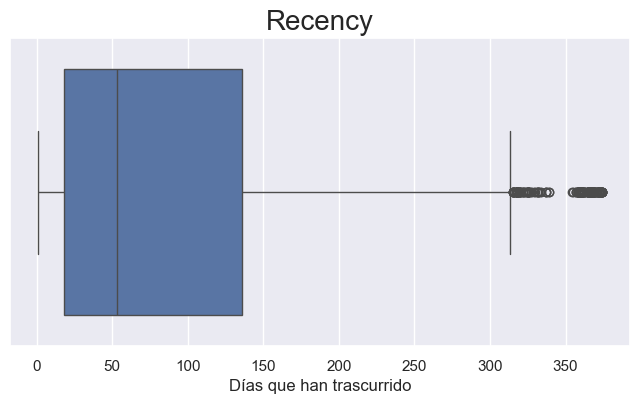

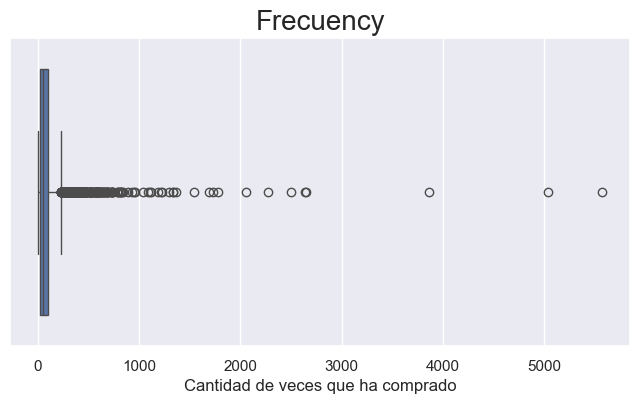

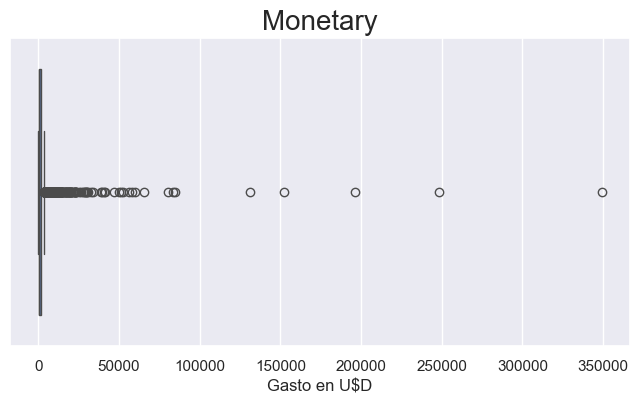

In [13]:
from numpy import size


for i in df_rfm.columns:
    ax = sns.boxplot(x = df_rfm[str(i)])
    sns.set(font="Arial")
    plt.title( str(i).capitalize(), fontsize=20)
    
    if (str(i) == 'recency'):
        ax.set(xlabel='Días que han trascurrido')
    elif(str(i) == 'frecuency'):
        ax.set(xlabel='Cantidad de veces que ha comprado') 
    elif(str(i) == 'monetary'):
        ax.set(xlabel='Gasto en U$D') 
    plt.show()

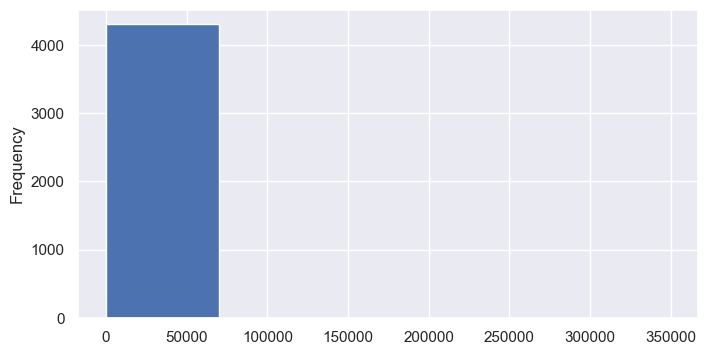

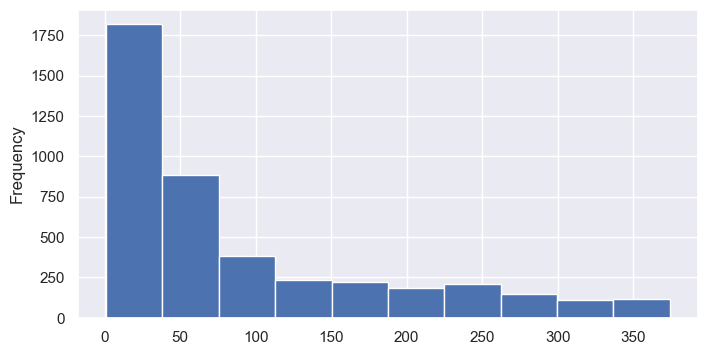

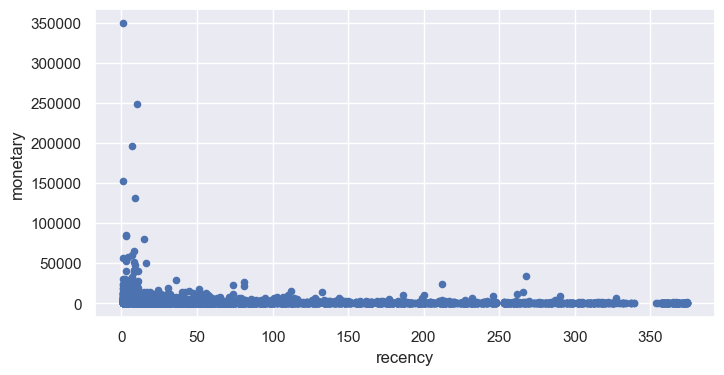

In [14]:
df_rfm.monetary.plot.hist(bins=5)
plt.show()
df_rfm.recency.plot.hist(bins=10)
plt.show()
df_rfm.plot("recency","monetary", kind="scatter")
plt.show()

<h4>K MEANS: Clustering</h4>
<p>Para usar esta técnica es necesario medir la distancia entre cada uno de los punto, por lo que es importante poder usar una técnica de escalamiento para estandarizar las medidas de distancia entre puntos no importando la variable, por ejemplo si tengo una medida de distancia de dinero que oscina entre 1 y 1,000000 y tengo una medida de frecuencia que oscina entre 1 y 100 ambas escalas estan muy lejanas por eso debo estandarizar.</p>
<p>
<p><b>Se pueden utilizar 2 diferentes técnicas las cuales son:</b> <i>Normalización</i> y <i>Standarización </i></p>
<p>Con la <b>NORMALIZACIÓN</b> las medidas variarian entre 0 y 1. </p> 

$ \huge X_{norm} = \frac {X-X_{min}} {X_{max} - x_{min}} \in[0,1] $

<p>Mientras que con la Standarización hablamos de la media y de la desviación standard de nuestros datos.</p>

$ \huge z = \frac{x  -  \mu}{\sigma} $
<br><br>
$ \large \mu =$ Media
<br>
$ \large \sigma = $ Desviación estandard 

<p>Para este ejercicio voy a utilizar la estandarización ya que con esta puedo simular la distribución normal que ira de -3 a 3 y sabré que cualquier valor que se encuentre fuera de este intevalo será un outlayer.</p>

### Procesamiento de los datos:

In [15]:
# proceso de normalización

df_log = np.log1p(df_rfm)

scaler = StandardScaler()
scaler.fit(df_log)
df_norm = scaler.transform(df_log)

# df_norm es devuelto como un arreglo por lo que debo convertirlo nuevamente 
# en un dataframe 
df_norm = pd.DataFrame(df_norm, columns=["recency", "frecuency", "monetary"], index= df_rfm.index)

df_norm.head()

,recency,frecuency,monetary
customer_id,,,
12346.0,0.966262,-0.200749,-0.540688
12347.0,-1.900165,0.394219,0.447651
12348.0,0.355000,-0.582831,-0.943904
12349.0,-0.055302,0.678152,0.996204
12351.0,-1.054928,-0.545943,-0.707671


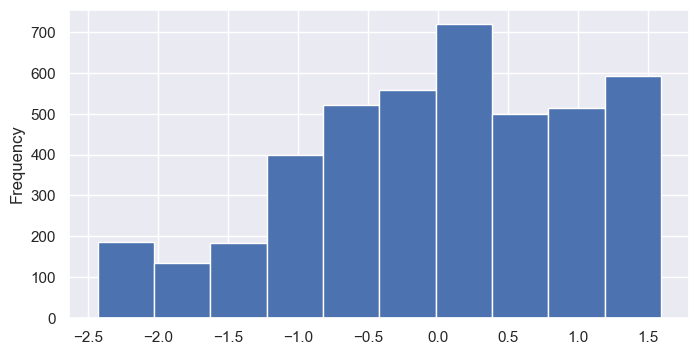

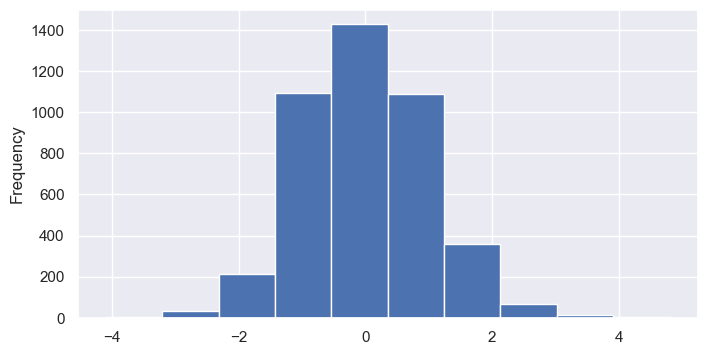

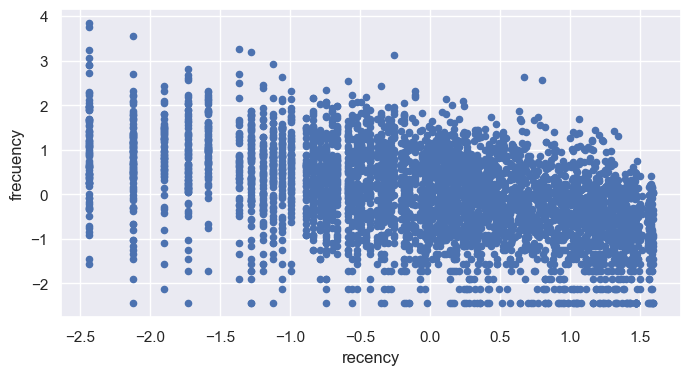

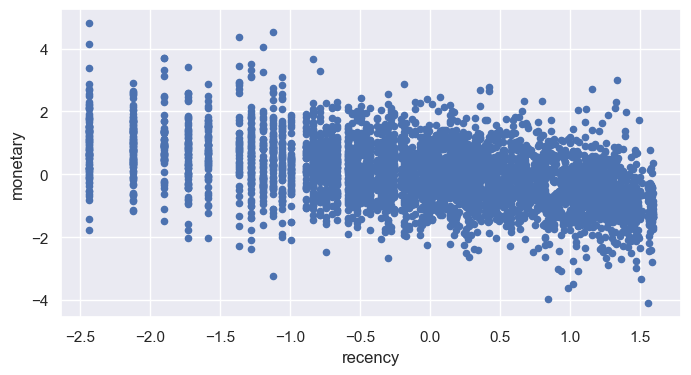

In [16]:
df_norm.recency.plot.hist()
plt.show()

# Me permite ver el comportamiento y se puede ver que es siguiendo la normal
df_norm.monetary.plot.hist()
plt.show()

# Me va a permitir observar cuantos clusters necesito hacer con Kmeans de forma visual
df_norm.plot.scatter("recency", "frecuency")
plt.show()
df_norm.plot.scatter("recency", "monetary")
plt.show()

### Clustering

In [17]:
# Le doy indicaciones a Kmeans de lo que necesito
kmeans = KMeans(n_clusters=4, random_state=1, n_init="auto")
# Con las instrucciones paso mi dataframe normalizado y standarizado para que lo
# trabaje kmeans y le coloque etiquetas
kmeans.fit(df_norm)

KMeans(n_clusters=4, n_init='auto', random_state=1)

In [18]:
# Obtengo la cantidad de puntos por cada cluster según la etiqueta devuelta por kmeans
#np.unique(kmeans.labels_, return_counts=True)
print(dict(pd.Series(kmeans.labels_).value_counts()))

{1: 1232, 0: 1225, 3: 952, 2: 903}


### Add clusters as data label
Ahora me toca poder capturar la información de mis clientes, básicamente lo que hago es etiquetar según el cluster que Kmeans haya encontrado para cada una de las lineas de mi DataFrame original que era df_rfm

In [19]:
# creo una columna en el DataFrame df_norm con la etiqueta devuelva por Kmeans
df_norm['Cluster'] = kmeans.labels_
# Hago que cada uno de estos valores sean del tipo categorico, de esta forma hago que
# pandas no los tome como numéricos.
df_norm['cluster'] = df_norm['Cluster'].astype('category') 

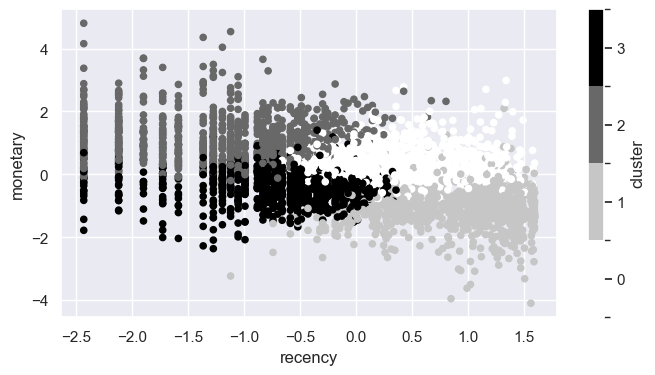

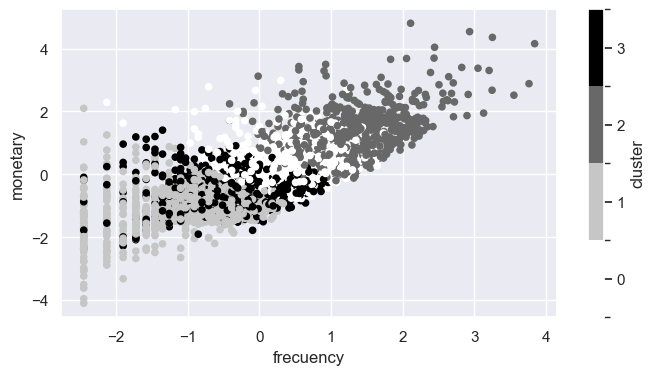

In [20]:
df_norm.plot(x='recency', y='monetary', c='cluster', kind='scatter')
plt.show()
df_norm.plot(x='frecuency', y='monetary', c='cluster', kind='scatter')
plt.show()

Estos gráficos son dificiles de leer porque la escala sigue estando estandarizada y transformada por esa razón voy a ir a mi DataFrame original y voy a tomar las gráficas desde los datos antes de transformar.
### Cluster segmentation.

In [21]:
# Le pego las etiquetas de categoria a mi cluster de datos original
df_rfm['cluster'] = kmeans.labels_
# Convierto la columna "cluster" en tipo categoria
df_rfm.cluster = df_rfm.cluster.astype('category')

df_rfm.groupby('cluster').agg(
    recency=('recency', 'mean'),
    frequency=('frecuency', 'mean'),
    monetary=('monetary', 'mean'),
    cluster_size=('monetary','count')
).round(2).sort_values(by='recency')


,recency,frequency,monetary,cluster_size
cluster,,,,
2,13.91,275.83,6580.70,903
3,25.12,35.79,571.30,952
0,99.42,85.90,1627.69,1225
1,190.64,15.66,285.58,1232


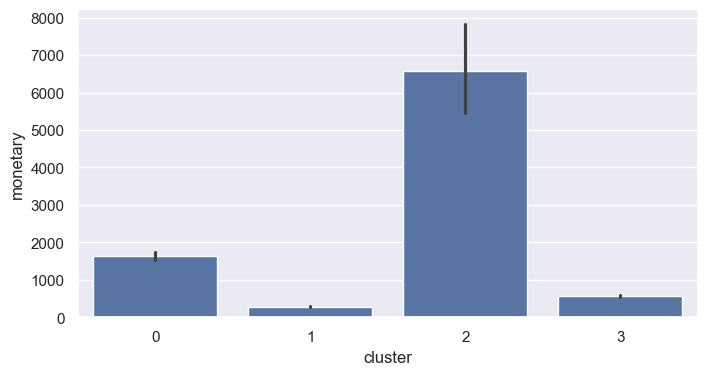

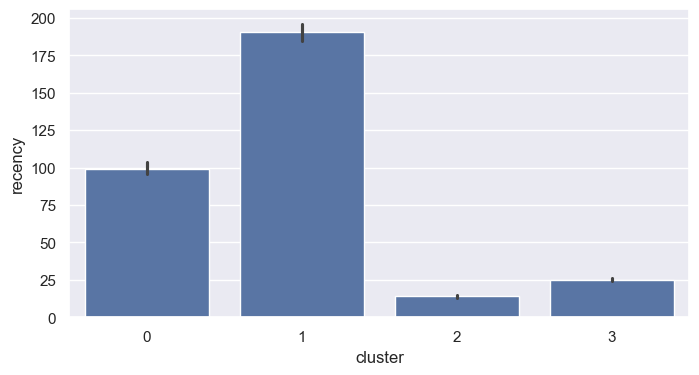

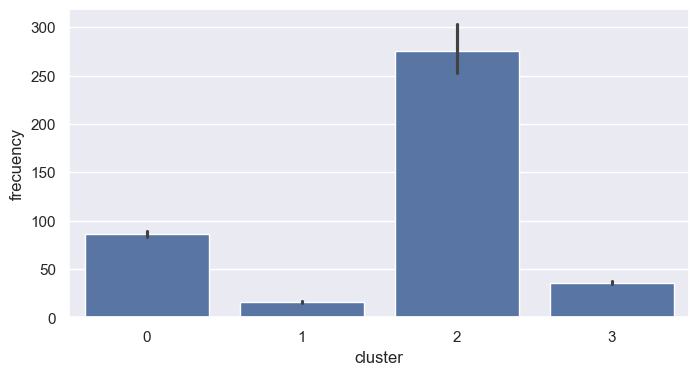

In [22]:
# Puedo ver el comportamiento de los clusters conforme a su consumo
sns.barplot(data=df_rfm, x='cluster', y='monetary')
plt.show()
sns.barplot(data=df_rfm, x='cluster', y='recency')
plt.show()
sns.barplot(data=df_rfm, x='cluster', y='frecuency')
plt.show()

#### CONCLUSION
Viendo los resultados de cada uno de los cluster, podemo decir que:

**El cluster 0** es un grupo de clientes que nos han dejado de visitar recientemente pero que cuando lo hicieron hicieron un número de transacciones altas y un gasto alto.

**El cluster 1** es el grupo de clientes que no nos compran desde hace mucho tiempo, tienen muy pocas transacciones y consecuentemente son los que menos han gastado con nosotros. ¿Sera que el grueso de los clientes es el tipo de cliente que solo nos compran una vez y ya no regresan?

**El cluster 2** es el grupo de clientes que nos han comprado recientemente, tienen la frecuencia más alta de compra y consecuentemente son los que más han gastado con nosotros.


**El cluster 3** es un grupo de clientes que son clientes que nos han visitado recientemente pero que su número de transacciones es escaso y consecuentemente lo qu ehan gastado con nosotros es relativamente poco.


Todo esto indica que la correlació entre la frecuencia de compra y el gasto tienen una correlación muy alta y positiva a mayor frecuencia mayor gasto.  Por lo que desde mercadeo se deberían crear estrategias para recuperar clientes, para incrementar la frecuencia de compras y para mantener los clientes que nos han comprado recientemente.



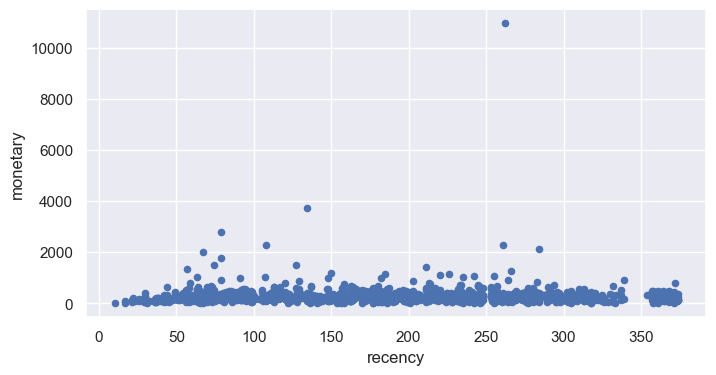

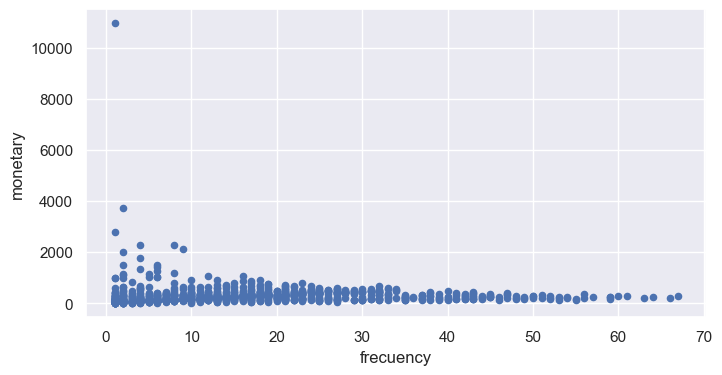

In [28]:
# Comportamiento de los clientes recency versus lo que gastan y el
# comportamiento de los clientes frecuency versus lo que gastan
# todo para el cluster 1 que son los clientes que tienen más tiempo sin visitarnos

df_rfm[df_rfm.cluster==1].plot(x='recency', y='monetary', kind="scatter")
plt.show()
df_rfm[df_rfm.cluster==1].plot(x='frecuency', y='monetary', kind="scatter")
plt.show()
